In [19]:
import theano
from theano import *
THEANO_FLAGS = "optimizer=fast_compile"

import numpy as np
import pandas as pd
from scipy.integrate import odeint, solve_ivp
from scipy.optimize import curve_fit
from scipy import stats
import arviz as az

import pymc3 as pm
from pymc3.ode import DifferentialEquation

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams.update({'font.size': 13, 'figure.figsize': (8, 6)})
import seaborn as sns
plt.style.use("seaborn-darkgrid")

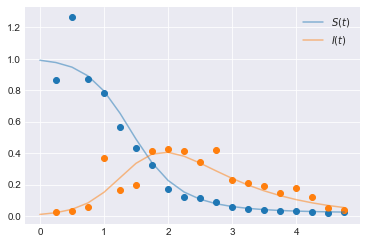

In [7]:
def SIR(y, t, p):
    ds = -p[0] * y[0] * y[1]
    di = p[0] * y[0] * y[1] - p[1] * y[1]
    return [ds, di]


times = np.arange(0, 5, 0.25)

beta, gamma = 4, 1.0
# Create true curves
y = odeint(SIR, t=times, y0=[0.99, 0.01], args=((beta, gamma),), rtol=1e-8)
# Observational model.  Lognormal likelihood isn't appropriate, but we'll do it anyway
yobs = np.random.lognormal(mean=np.log(y[1::]), sigma=[0.2, 0.3])

plt.plot(times[1::], yobs, marker="o", linestyle="none")
plt.plot(times, y[:, 0], color="C0", alpha=0.5, label=f"$S(t)$")
plt.plot(times, y[:, 1], color="C1", alpha=0.5, label=f"$I(t)$")
plt.legend()
plt.show()

In [49]:
sir_model = DifferentialEquation(
    func=SIR,
    times=np.arange(0.25, 5, 0.25),
    n_states=2,
    n_theta=2,
    t0=0,
)

In [50]:
sir_curves = sir_model(y0=[0.99, 0.01], theta=[beta, lam])
sir_curves

DifferentialEquation{func=<function SIR at 0x11b1d7c10>, times=(0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75), n_states=2, n_theta=2, t0=0}.0

In [ ]:
def sir_model(y, t, alpha, beta):
    [S, I, R] = y
    dS = - alpha * S/N * I
    dI = alpha * S/N * I - beta * I
    dR = beta * I
    return [dS, dI, dR]

def ode_solver(y0, t_span, t_eval, params):
    
    solution_ODE = solve_ivp(
        fun=sir_model, 
        t_span=t_span, 
        t_eval=t_eval,
        y0=y0,
        args=*params,
        method='LSODA'
    )
    return solution_ODE



In [59]:
sir_model = DifferentialEquation(
    func=SIR,
    times=np.arange(0.25, 5, 0.25),
    n_states=2,
    n_theta=2,
    t0=0,
)

with pm.Model() as model4:
    sigma = pm.HalfCauchy("sigma", 1, shape=2)

    # R0 is bounded below by 1 because we see an epidemic has occured
    R0 = pm.Bound(pm.Normal, lower=1)("R0", 2, 3)
    lam = pm.Lognormal("lambda", pm.math.log(2), 2)
    beta = pm.Deterministic("beta", lam * R0)

    sir_curves = sir_model(y0=[0.99, 0.01], theta=[beta, lam])

    Y = pm.Lognormal("Y", mu=pm.math.log(sir_curves), sigma=sigma, observed=yobs)

    trace = pm.sample(2000, tune=1000, target_accept=0.9, cores=1)
    data = az.from_pymc3(trace=trace)

/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lambda, R0, sigma]


/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Sampling 1 chain for 16 tune and 0 draw iterations (16 + 0 draws total) took 4 seconds.
No posterior samples. Unable to run convergence checks


In [61]:
sir_curves

Elemwise{log,no_inplace}.0

In [11]:
trace

<MultiTrace: 2 chains, 2000 iterations, 7 variables>

The following section is based on example from: https://www.kaggle.com/volpatto/covid-19-study-with-epidemiology-models/data?select=countries+of+the+world.csv

In [26]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pymc3 as pm # for uncertainty quantification and model calibration
from scipy.integrate import solve_ivp # to solve ODE system
from scipy import optimize # to solve minimization problem from least-squares fitting
#from numba import jit # to accelerate ODE system RHS evaluations
import theano # to control better pymc3 backend and write a wrapper
import theano.tensor as t # for the wrapper to a custom model to pymc3
import matplotlib.pyplot as plt

seed = 12345 # for the sake of reproducibility :)
np.random.seed(seed)

plt.style.use('seaborn-talk') # beautify the plots!

THEANO_FLAGS='optimizer=fast_compile'

In [27]:
df_covid = pd.read_csv("datasets/covid_19_clean_complete.csv", parse_dates=['Date'])
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49068 entries, 0 to 49067
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Province/State  14664 non-null  object        
 1   Country/Region  49068 non-null  object        
 2   Lat             49068 non-null  float64       
 3   Long            49068 non-null  float64       
 4   Date            49068 non-null  datetime64[ns]
 5   Confirmed       49068 non-null  int64         
 6   Deaths          49068 non-null  int64         
 7   Recovered       49068 non-null  int64         
 8   Active          49068 non-null  int64         
 9   WHO Region      49068 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 3.7+ MB


In [28]:
columns_to_filter_cases = ["Country/Region", "Date", "Confirmed", "Deaths"]
df_covid_cases = df_covid[columns_to_filter_cases]
df_covid_cases.head()

,Country/Region,Date,Confirmed,Deaths
0,Afghanistan,2020-01-22,0,0
1,Albania,2020-01-22,0,0
2,Algeria,2020-01-22,0,0
3,Andorra,2020-01-22,0,0
4,Angola,2020-01-22,0,0


In [29]:
print(f"First day entry:\t {df_covid['Date'].min()}")
print(f"Last day reported:\t {df_covid['Date'].max()}")
print(f"Total of tracked days:\t {df_covid['Date'].max() - df_covid['Date'].min()}")

First day entry:	 2020-01-22 00:00:00
Last day reported:	 2020-07-27 00:00:00
Total of tracked days:	 187 days 00:00:00


In [30]:
df_covid.rename(
    columns={
        'Date': 'date', 
        'Province/State':'state',
        'Country/Region':'country',
        'Last Update':'last_updated',
        'Confirmed': 'confirmed',
        'Deaths':'deaths',
        'Recovered':'recovered'}, 
    inplace=True
)
df_covid.columns

Index(['state', 'country', 'Lat', 'Long', 'date', 'confirmed', 'deaths',
       'recovered', 'Active', 'WHO Region'],
      dtype='object')

In [31]:
df_covid['active'] = df_covid['confirmed'] - df_covid['deaths'] - df_covid['recovered']

In [32]:
df_covid['country'] = df_covid['country'].replace('Mainland China', 'China')

In [33]:
df_grouped = df_covid.groupby('date')['date', 'confirmed', 'deaths'].sum().reset_index()
df_grouped.head()

<ipython-input-33-e9ceae2cc2cf>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_grouped = df_covid.groupby('date')['date', 'confirmed', 'deaths'].sum().reset_index()


,date,confirmed,deaths
0,2020-01-22,555,17
1,2020-01-23,654,18
2,2020-01-24,941,26
3,2020-01-25,1434,42
4,2020-01-26,2118,56


In [34]:
def get_df_country_cases(df: pd.DataFrame, country_name: str) -> pd.DataFrame:
    df_grouped_country = df[df['country'] == country_name].reset_index()
    df_grouped_country_date = df_grouped_country.groupby('date')['date', 'confirmed', 'deaths'].sum().reset_index()
    df_grouped_country_date["confirmed_marker"] = df_grouped_country_date.shape[0] * ['Confirmed']
    df_grouped_country_date["deaths_marker"] = df_grouped_country_date.shape[0] * ['Deaths']
    return df_grouped_country_date

df_grouped_italy = get_df_country_cases(df_covid, "Italy")
df_grouped_italy.tail()

<ipython-input-34-634c841a7a1e>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_grouped_country_date = df_grouped_country.groupby('date')['date', 'confirmed', 'deaths'].sum().reset_index()


,date,confirmed,deaths,confirmed_marker,deaths_marker
183,2020-07-23,245338,35092,Confirmed,Deaths
184,2020-07-24,245590,35097,Confirmed,Deaths
185,2020-07-25,245864,35102,Confirmed,Deaths
186,2020-07-26,246118,35107,Confirmed,Deaths
187,2020-07-27,246286,35112,Confirmed,Deaths


In [35]:
df_italy_cases_by_day = df_grouped_italy[df_grouped_italy.confirmed > 0]
df_italy_cases_by_day = df_italy_cases_by_day.reset_index(drop=True)
df_italy_cases_by_day['day'] = df_italy_cases_by_day.date.apply(lambda x: (x - df_italy_cases_by_day.date.min()).days)
reordered_columns = ['date', 'day', 'confirmed', 'deaths', 'confirmed_marker', 'deaths_marker']
df_italy_cases_by_day = df_italy_cases_by_day[reordered_columns]
df_italy_cases_by_day.head()

,date,day,confirmed,deaths,confirmed_marker,deaths_marker
0,2020-01-31,0,2,0,Confirmed,Deaths
1,2020-02-01,1,2,0,Confirmed,Deaths
2,2020-02-02,2,2,0,Confirmed,Deaths
3,2020-02-03,3,2,0,Confirmed,Deaths
4,2020-02-04,4,2,0,Confirmed,Deaths


#### Modeling

In [36]:
def seird_model(t, X, alpha=1/5, beta=1, gamma=0, zeta=1/15, delta=0.02):
    """
    A modified SEIR model in order to take into account deaths.
    """
    S, E, I, R, D = X
    S_prime = - beta * S * I - gamma * E * S
    E_prime = beta * S * I - alpha * E + gamma * E * S
    I_prime = alpha * E - zeta * I - delta * I
    R_prime = zeta * I
    D_prime = delta * I
    return S_prime, E_prime, I_prime, R_prime, D_prime

In [37]:
def seird_ode_solver(y0, t_span, t_eval, beta=1, gamma=0, delta=0.02, alpha=1/4, zeta=1/14):
    solution_ODE = solve_ivp(
        fun=lambda t, y: seird_model(t, y, alpha=alpha, beta=beta, gamma=gamma, zeta=zeta, delta=delta), 
        t_span=t_span, 
        y0=y0,
        t_eval=t_eval,
        method='LSODA'
    )
    
    return solution_ODE

In [38]:
df_population = pd.read_csv("datasets/covid.csv")
df_population

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0","3,2","12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38"
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5","71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"
2,Algeria,NORTHERN AFRICA,32930091,2381740,"13,8","0,04","-0,39",31,6000.0,"70,0","78,1","3,22","0,25","96,53",1,"17,14","4,61","0,101","0,6","0,298"
3,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000.0,"97,0","259,5",10,15,75,2,"22,46","3,27",NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,71201,468,"152,1","0,00","6,6","4,05",19000.0,"100,0","497,2","2,22",0,"97,78",3,"8,71","6,25",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,West Bank,NEAR EAST,2460492,5860,"419,9","0,00","2,98","19,62",800.0,NaN,"145,2","16,9","18,97","64,13",3,"31,67","3,92","0,09","0,28","0,63"
223,Western Sahara,NORTHERN AFRICA,273008,266000,"1,0","0,42",NaN,NaN,NaN,NaN,NaN,"0,02",0,"99,98",1,NaN,NaN,NaN,NaN,"0,4"
224,Yemen,NEAR EAST,21456188,527970,"40,6","0,36",0,"61,5",800.0,"50,2","37,2","2,78","0,24","96,98",1,"42,89","8,3","0,135","0,472","0,393"
225,Zambia,SUB-SAHARAN AFRICA,11502010,752614,"15,3","0,00",0,"88,29",800.0,"80,6","8,2","7,08","0,03","92,9",2,41,"19,93","0,22","0,29","0,489"


In [39]:
brazil_population = float(df_population[df_population.Country == 'Brazil '].Population)
italy_population = float(df_population[df_population.Country == 'Italy '].Population)
china_population = float(df_population[df_population.Country == 'China '].Population)
spain_population = float(df_population[df_population.Country == 'Spain '].Population)
iran_population = float(df_population[df_population.Country == 'Iran '].Population)
us_population = float(df_population[df_population.Country == 'United States '].Population)
target_population = italy_population
target_population

58133509.0

In [40]:
df_target_country = df_italy_cases_by_day
S0, E0, I0, R0, D0 = target_population, 5 * float(df_target_country.confirmed[0]), float(df_target_country.confirmed[0]), 0., 0.

y0_sir = S0 / target_population, I0 / target_population, R0  # SIR IC array
y0_sird = S0 / target_population, I0 / target_population, R0, D0  # SIRD IC array
y0_seir = S0 / target_population, E0 / target_population, I0 / target_population, R0  # SEIR IC array
y0_seird = S0 / target_population, E0 / target_population, I0 / target_population, R0, D0  # SEIRD IC array

In [41]:
def seird_least_squares_error_ode(par, time_exp, f_exp, fitting_model, initial_conditions):
    args = par
    f_exp1, f_exp2 = f_exp
    time_span = (time_exp.min(), time_exp.max())
    
    y_model = fitting_model(initial_conditions, time_span, time_exp, *args)
    simulated_time = y_model.t
    simulated_ode_solution = y_model.y
    _, _, simulated_qoi1, _, simulated_qoi2 = simulated_ode_solution
    
    residual1 = f_exp1 - simulated_qoi1
    residual2 = f_exp2 - simulated_qoi2

    weighting_for_exp1_constraints = 1e0
    weighting_for_exp2_constraints = 1e0
    return weighting_for_exp1_constraints * np.sum(residual1 ** 2.0) + weighting_for_exp2_constraints * np.sum(residual2 ** 2.0)

In [42]:
def callback_de(xk, convergence):
    print(f'parameters = {xk}')

In [43]:
data_time = df_target_country.day.values.astype(np.float64)
infected_individuals = df_target_country.confirmed.values / target_population
dead_individuals = df_target_country.deaths.values / target_population

In [ ]:
num_of_parameters_to_fit_sir = 1
# bounds_sir = num_of_parameters_to_fit_sir * [(0, 1)]
bounds_seird = [(0, 1), (0, 1), (0, 0.2)]

result_seird = optimize.differential_evolution(
    seird_least_squares_error_ode, 
    bounds=bounds_seird, 
    args=(data_time, [infected_individuals, dead_individuals], seird_ode_solver, y0_seird), 
    popsize=300,
    strategy='best1bin',
    tol=1e-2,
    recombination=0.7,
    #     mutation=0.7,
    maxiter=100,
    disp=True,
    seed=seed,
    callback=callback_de,
    workers=-1
)

print(result_seird)

In [44]:
def sir_model(t, X, beta=1, zeta=1/15):
    S, I, R = X
    S_prime = - beta * S * I
    I_prime = beta * S * I - zeta * I
    R_prime = zeta * I
    return S_prime, I_prime, R_prime

In [45]:
def sir_ode_solver(y0, t_span, t_eval, beta=1, zeta=1/14):
    solution_ODE = solve_ivp(
        fun=lambda t, y: sir_model(t, y, beta=beta, zeta=zeta), 
        t_span=t_span, 
        y0=y0,
        t_eval=t_eval,
        method='LSODA'
    )
    
    return solution_ODE

In [46]:
@theano.compile.ops.as_op(itypes=[t.dvector, t.dvector, t.dvector, t.dscalar], otypes=[t.dvector])
def sir_ode_solver_wrapper(time_exp, f_observations, initial_conditions, beta):
    time_span = (time_exp.min(), time_exp.max())
    
    zeta = 1/14
    y_model = sir_ode_solver(initial_conditions, time_span, time_exp, beta, zeta)
    simulated_time = y_model.t
    simulated_ode_solution = y_model.y
    _, simulated_qoi, _ = simulated_ode_solution

    return simulated_qoi

In [47]:
with pm.Model() as model_mcmc:
    # Prior distributions for the model's parameters
    beta = pm.Uniform('beta', lower=0.2, upper=0.4)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic('sir_model', sir_ode_solver_wrapper(
        theano.shared(data_time), 
        theano.shared(infected_individuals), 
        theano.shared(np.array(y0_sir)),
        beta,
        )
    )

    # Variance related to population fraction amount! Let's assume a variance of 100 individuals, since there are cases that have been not tracked
    variance = (100 / target_population) * (100 / target_population)
    standard_deviation = np.sqrt(variance)
    likelihood_model = pm.Normal('likelihood_model', mu=fitting_model, sigma=standard_deviation, observed=infected_individuals)

    # The Monte Carlo procedure driver
    step = pm.step_methods.Metropolis()
    sir_trace = pm.sample(4500, step=step)

/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [beta]


RuntimeError: Chain 0 failed.

In [ ]:
from scipy.integrate import odeint, solve_ivp
import numpy as np
import matplotlib.pyplot as plt
from theano.compile.ops import as_op
import theano.tensor as T
import pymc3 as pm
import copy
from sys import exit
import multiprocessing as mp
mp.set_start_method("fork")

time = 10
Nt = 11
tt = np.linspace(0,time, Nt+1)
y0 = [1,2,0]
k1, k2 = 1, 1
def real_equat(t,c):
    da_dt = -k1*c[0]
    da1_dt = -k2*c[1]
    db_dt = k1*c[0] + k2*c[1]
    return da_dt, da1_dt, db_dt
z = solve_ivp(real_equat, t_span=[0,time], t_eval= tt, y0 = y0)
def lv(xdata, k1=k1, k2=k2):
    def equat(c,t):
        da_dt = -k1*c[0]
        da1_dt = -k2*c[1]
        db_dt = k1*c[0] + k2*c[1]
        return da_dt, da1_dt, db_dt
    Y, dict = odeint(equat,y0,tt,full_output=True)
    return Y
a = z.y
ydata = copy.copy(a)

yerror = 10*np.random.rand(Nt+1)
ydata += np.random.normal(0.0, np.sqrt(yerror))
ydata = np.ravel(ydata)

@as_op(itypes=[T.dscalar, T.dscalar], otypes=[T.dvector])

def func(al,be):
    Q = lv(tt, k1 = al, k2 = be)
    return np.ravel(Q)
niter = 10
model = pm.Model()
with model:
    # Priors for unknown model parameters
    k1 = pm.Uniform('k1', upper = 1.2, lower = 0.8)
    k2 = pm.Uniform('k2', upper = 1.2, lower = 0.8)

    # Expected value of outcome
    mu = func(k1,k2)


    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=0.2, observed=ydata)

    trace = pm.sample(100)